# Implementing Vanilla U-Net
## Author:  JA Engelbrecht
## Supervisor:  Prof Martin Nieuwoudt
## Co-supervisor: Dr ST Malherbe

# Import Libraries

In [1]:
from matplotlib import rc
from jupyterthemes import jtplot
from skimage.util import montage as montage2d
import MyFunctions.auxillaryFunctions as AuxFunctions
import MyFunctions.pathFunctions as PathFunctions
import UNets.Vanilla.UNet_Vanilla as UNet

from MyFunctions.LoadImages import LoadImages
from MyFunctions.CreatePaths import CreatePaths
from CLR.clr_callback import *

import SimpleITK as sitk
import tensorflow as tf
import pandas as pd
import numpy as np
import os

from tensorflow.keras.optimizers import SGD

from sklearn.model_selection import train_test_split

############ Plot Images/Graphs Functions ############

from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = LinearSegmentedColormap.from_list('mycmap', ['black', 'orange', 'red'])


rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams.update({'font.size': 12})


def set_size(width='thesis', fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 398
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


def showCTImage(IMG, SIZE):
    plt.figure(figsize=(SIZE, SIZE))
    plt.imshow(IMG, alpha=1, cmap='gray')
    plt.axis('off')
    plt.show()


def showCTMontage(IMG, SIZE):
    plt.figure(figsize=(SIZE, SIZE))
    plt.imshow(montage2d(IMG), alpha=1, cmap='gray')
    plt.axis('off')
    plt.show()


def showCTMontageOverlay(IMG1, IMG2, SIZE=15, SaveFig=False, save_fig_name=""):
    fig, ax = plt.subplots(figsize=(SIZE, SIZE))
    try:
        ax.imshow(montage2d(IMG1), alpha=1, cmap='gray')
    except:
        print("Error: Img 1")
    try:
        ax.imshow(montage2d(IMG2, fill=0), alpha=0.5,
                  cmap=cmap, interpolation='none')
    except:
        print("Error: Img 2")
    plt.axis('off')

    if SaveFig:
        save_fig_path = os.path.join(os.curdir, "SavedFigures")
        plt.savefig(os.path.join(save_fig_path,
                                 save_fig_name+".pdf"), bbox_inches='tight')
    plt.show()
######################################################

# Set Variables

In [2]:
# Change Class Variable below for different paths e.g. CT/PET
path = CreatePaths(DeviceFlag="PC", ScanTypeFlag="CT", TrainTestFlag="Train")

DATA_PATH = path.data_path
IMGS_PATH = path.imgPath()
MSKS_PATH = path.mskPath()
OUTPUT_PATH = path.outputPath()

ORIENTATION_ENSEMBLE = ["Axial", "Sagittal", "Coronal"]

print("Image Path: "+"\t"+IMGS_PATH+"\n"+"Mask Path: " +
      "\t"+MSKS_PATH+"\n"+"Output Path: "+"\t"+OUTPUT_PATH)

Image Path: 	D:/Masters_Repo/TrainingData/CT/imgs
Mask Path: 	D:/Masters_Repo/TrainingData/CT/masks
Output Path: 	D:/Output


# Import and Process Scans

In [3]:
ScanType = "CT"
n_Scans = 10
Orientation = "Axial"

CT_Images = LoadImages(ScanType=ScanType, ScanClass="Image",
                       ImgPath=IMGS_PATH, n_Scans=n_Scans, Orientation=Orientation).LoadScans()
CT_Masks = LoadImages(ScanType=ScanType, ScanClass="Mask",
                      MskPath=MSKS_PATH, n_Scans=n_Scans, Orientation=Orientation).LoadScans()

########################## Split Into Train and Test Set ##########################
X, X_Val, y, y_Val = train_test_split(
    CT_Images, CT_Masks, test_size=0.15, random_state=42)

del CT_Images, CT_Masks

y = tf.cast(y, dtype='float32')
y_Val = tf.cast(y_Val, dtype='float32')

Reading the following CT Images:
CB_001_CT_M0.nii.gz
CB_002_CT_M0.nii.gz
CB_003_CT_M0.nii.gz
CB_004_CT_M0.nii.gz
CB_005_CT_M0.nii.gz
CB_007_CT_M0.nii.gz
CB_009_CT_M0.nii.gz
CB_013_CT_M0.nii.gz
CB_020_CT_M0.nii.gz
CB_021_CT_M0.nii.gz

Reading the following CT Masks:
CB_001_CT_M0.nii.gz
CB_002_CT_M0.nii.gz
CB_003_CT_M0.nii.gz
CB_004_CT_M0.nii.gz
CB_005_CT_M0.nii.gz
CB_007_CT_M0.nii.gz
CB_009_CT_M0.nii.gz
CB_013_CT_M0.nii.gz
CB_020_CT_M0.nii.gz
CB_021_CT_M0.nii.gz



## View Imported Scans Overlayed with Masks

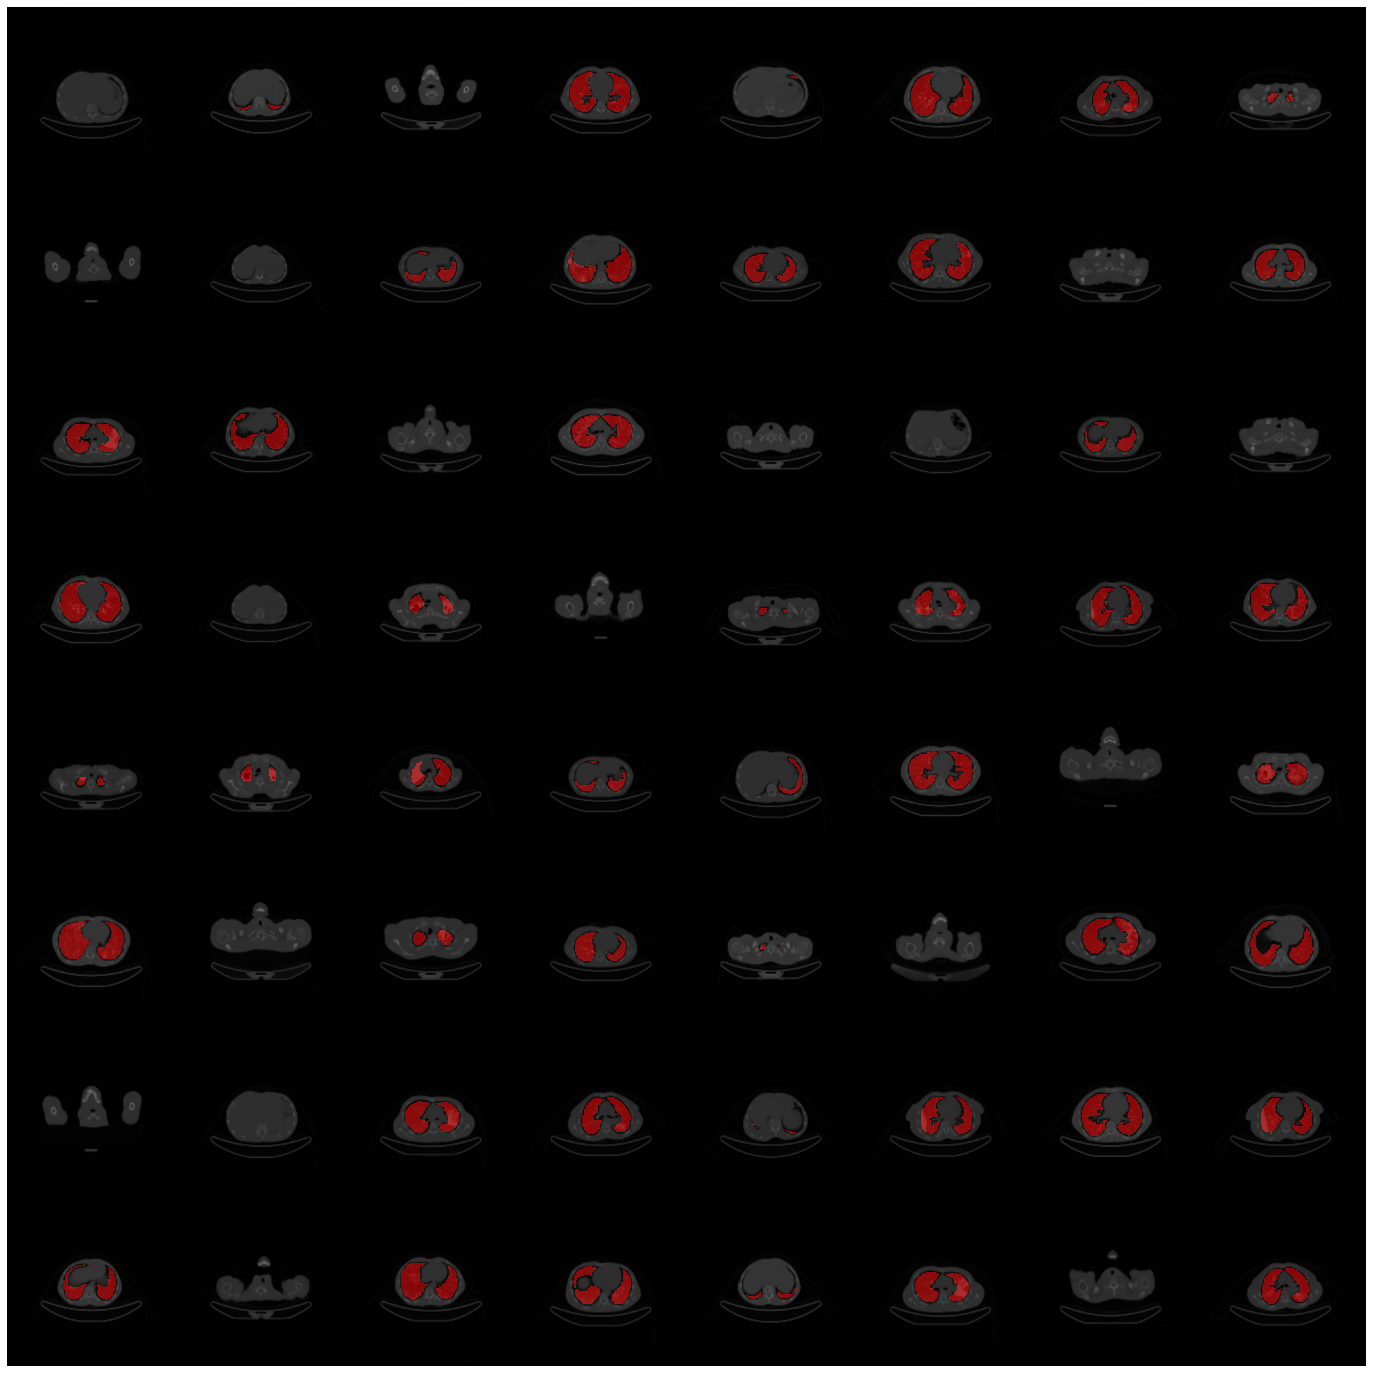

In [4]:
y_mask = np.copy(y)
y_mask = np.ma.masked_where(y == 0.5, y, copy=False)
showCTMontageOverlay(IMG1=X[500:564, :, :], IMG2=y[500:564, :, :],
                     SIZE=25, SaveFig=True, save_fig_name="Masks on Images")

## Expand Arrays with a 4'th Singular Dimension (Grayscale Images)

In [5]:
X = np.expand_dims(X, axis=3)
y = np.expand_dims(y, axis=3)
X_Val = np.expand_dims(X_Val, axis=3)
y_Val = np.expand_dims(y_Val, axis=3)

# U-Net

## Preparing to Create U-Net

In [6]:
############## Functions to Log Training of U-Net ##############
def get_run_logdir(root_logdir, input_string):
    import time
    if not input_string:
        run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    else:
        run_id = os.path.join(
            input_string, time.strftime("run_%Y_%m_%d-%H_%M_%S"))
    return os.path.join(root_logdir, run_id)


def create_logdir(modelName):
    root_logdir = os.path.join(os.curdir, "My_logs")
    run_logdir = get_run_logdir(root_logdir, modelName)
    return run_logdir
################################################################

########## Custom Loss Function for Dice Coeffiecient ##########


def dice_coe(output, target, loss_type='jaccard', axis=(1, 2, 3), smooth=1e-5):
    """Soft dice (Sørensen or Jaccard) coefficient for comparing the similarity
    of two batch of data, usually be used for binary image segmentation
    i.e. labels are binary. The coefficient between 0 to 1, 1 means totally match.

    Parameters
    -----------
    output : Tensor
        A distribution with shape: [batch_size, ....], (any dimensions).
    target : Tensor
        The target distribution, format the same with `output`.
    loss_type : str
        ``jaccard`` or ``sorensen``, default is ``jaccard``.
    axis : tuple of int
        All dimensions are reduced, default ``[1,2,3]``.
    smooth : float
        This small value will be added to the numerator and denominator.
            - If both output and target are empty, it makes sure dice is 1.
            - If either output or target are empty (all pixels are background), dice = ```smooth/(small_value + smooth)``, then if smooth is very small, dice close to 0 (even the image values lower than the threshold), so in this case, higher smooth can have a higher dice.

    Examples
    ---------
    >>> import tensorlayer as tl
    >>> outputs = tl.act.pixel_wise_softmax(outputs)
    >>> dice_loss = 1 - tl.cost.dice_coe(outputs, y_)

    References
    -----------
    - `Wiki-Dice <https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient>`__

    """
    inse = tf.reduce_sum(output * target, axis=axis)
    if loss_type == 'jaccard':
        l = tf.reduce_sum(output * output, axis=axis)
        r = tf.reduce_sum(target * target, axis=axis)
    elif loss_type == 'sorensen':
        l = tf.reduce_sum(output, axis=axis)
        r = tf.reduce_sum(target, axis=axis)
    else:
        raise Exception("Unknow loss_type")
    # old axis=[0,1,2,3]
    # dice = 2 * (inse) / (l + r)
    # epsilon = 1e-5
    # dice = tf.clip_by_value(dice, 0, 1.0-epsilon) # if all empty, dice = 1
    # new haodong
    dice = (2. * inse + smooth) / (l + r + smooth)
    ##
    dice = tf.reduce_mean(dice, name='dice_coe')
    return 1-dice
################################################################

## Callbacks for Training

In [7]:
MyModelName = 'U-Net_Vanilla_' + Orientation
MyLogdir = create_logdir(MyModelName)
MyModelSaveRoot = os.path.join(os.curdir, "TrainedModels")
MyModelSavePath = os.path.join(MyModelSaveRoot, MyModelName+".h5")

print(MyLogdir)
print(MyModelSavePath)
print(MyModelName)

.\My_logs\U-Net_Vanilla_Axial\run_2020_07_23-14_29_45
.\TrainedModels\U-Net_Vanilla_Axial.h5
U-Net_Vanilla_Axial


In [8]:
csv_logger_cb = tf.keras.callbacks.CSVLogger(
    os.path.join(MyModelSaveRoot, MyModelName+".csv"), append=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(MyModelSavePath,
                                                   monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True, monitor='val_loss')
clr_triangular_cb = CyclicLR(
    base_lr=0.001, max_lr=0.006, mode='triangular2', step_size=5*X.shape[0])
tensorboard_cb = tf.keras.callbacks.TensorBoard(MyLogdir)

## Create U-Net

In [9]:
MyModel = UNet.UNet_Vanilla(input_shape=(256, 256, 1)).CreateUnet()
MyModel.compile(optimizer=SGD(momentum=0.9, nesterov=True),
                loss=dice_coe, metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________

### Document Compile Parameters

In [10]:
Optimizer = "SGD, Momentum = 0.9, Nestrov = True"
loss = "Soft dice (Jaccard)"

### Set Training Patameters

In [11]:
batch_size = 10
epochs = 10

## Train U-Net

In [ ]:
MyModel.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_Val, y_Val),
            callbacks=[checkpoint_cb, early_stopping_cb, clr_triangular_cb, tensorboard_cb, csv_logger_cb])

In [ ]:
clr_triangular_cb._reset()

In [ ]:
MyModel.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_Val, y_Val),
            callbacks=[checkpoint_cb, early_stopping_cb, clr_triangular_cb, tensorboard_cb, csv_logger_cb])

## Load U-Net

In [12]:
MyModel.load_weights(MyModelSavePath)

# Write Model Parameters to Text File

In [ ]:
MyModelParameters_Strings = ["ScanType", "n_Scans",
                             "Orientation", "Optimizer", "Loss", "batch_size", "epochs"]
MyModelParameters_values = [ScanType, n_Scans,
                            Orientation, Optimizer, loss, batch_size, epochs*2]

TextFileName = MyModelName+".txt"
TextFilePath = os.path.join(os.curdir, "TrainedModels", TextFileName)

with open(TextFilePath, "w") as file:
    file.write("Parameters for " + MyModelName + ":\n\n")
    for parameter in enumerate(MyModelParameters_Strings):
        file.write(parameter[1] + ": " +
                   str(MyModelParameters_values[parameter[0]])+"\n")
    file.close()

# Check Performance on Test Set
## View Predicted Images Over Masks

In [13]:
try:
    y_predict = MyModel.predict(X_Val, batch_size=10, verbose=1)
except:
    X_Val = np.squeeze(X_Val)
    print("Error: Input to Model has to be 4D (x, y, x, 1)")
    print("Reshaping..")
    X_Val = np.expand_dims(X_Val, axis=3)
    y_predict = MyModel.predict(X_Val, batch_size=10, verbose=1)

384/384 [==============================] - 12s 30ms/sample


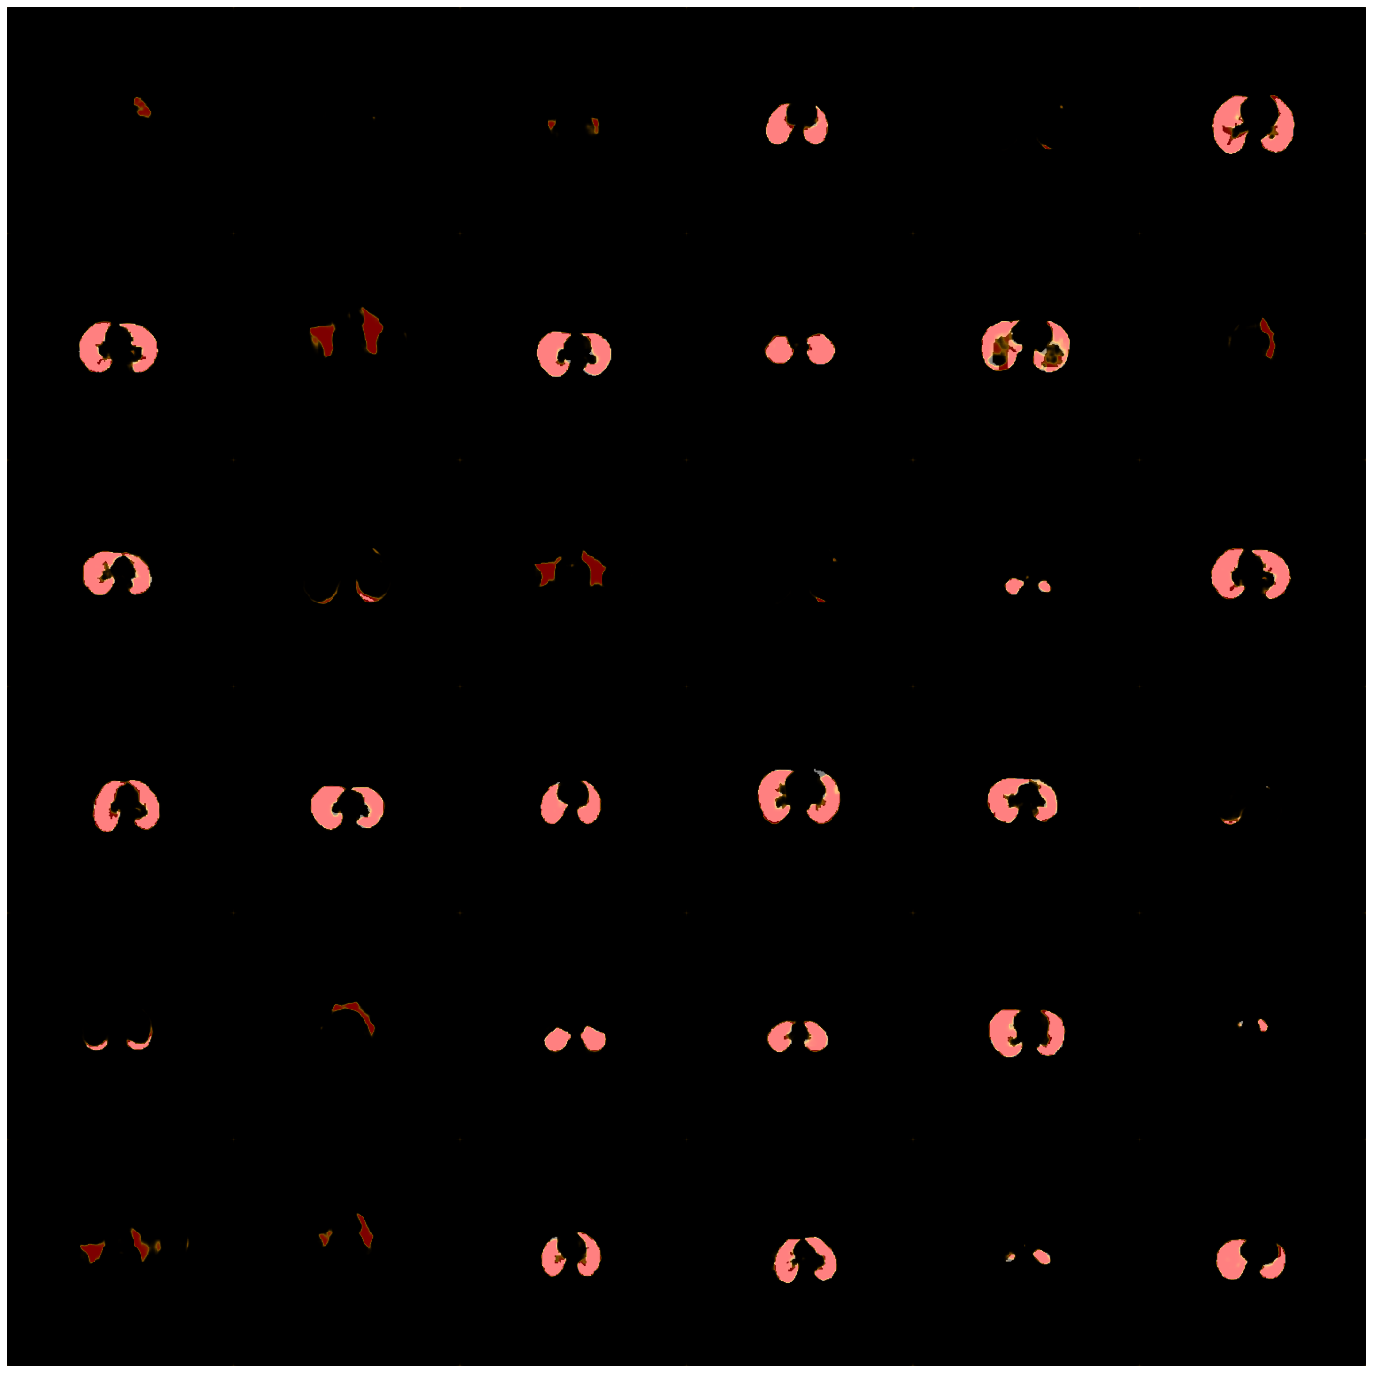

In [14]:
y_predict = np.squeeze(y_predict)
X_Val = np.squeeze(X_Val)

try:
    X_Val = np.squeeze(X_Val)
except:
    pass
try:
    y_threshold = np.squeeze(y_threshold)
except:
    pass
try:
    y_Val = np.squeeze(y_Val)
except:
    pass

y_new = np.ma.masked_where(y_predict > 0, y_predict, copy=False)

showCTMontageOverlay(IMG1=y_Val[300:336, :, :],
                     IMG2=y_new[300:336, :, :], SIZE=25, SaveFig=True, save_fig_name="Predicted Masks on Actual Masks")

## Plot Training History

In [15]:
history = pd.read_csv(os.path.join(MyModelSaveRoot, MyModelName + ".csv"))

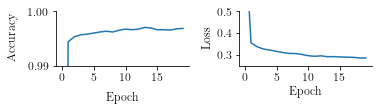

In [16]:
fig, axs = plt.subplots(1, 2, figsize=set_size(subplots=(1, 2)))

for ax in axs.flat:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))

axs[0].set_ylim((0.99, 1))
axs[0].set_xlabel('Epoch', labelpad=10)
axs[0].set_ylabel('Accuracy', labelpad=10)
axs[0].plot(history.accuracy)

axs[1].set_ylim((0.25, 0.5))
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].plot(history.loss)

fig.tight_layout()

save_path = os.path.join(os.curdir, "SavedFigures")
save_name = "UNet_Vanilla_Accuracy_Loss"
plt.savefig(os.path.join(save_path, save_name+".pdf"), bbox_inches='tight')